In [1]:
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp
from typing import Tuple, NamedTuple, Optional
from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.dct import colxfm
from cued_sf2_lab.lbt import pot_ii
from scipy.optimize import minimize
from simple_lbt_functions import *
from math import floor, ceil
from sys import stdout as so
from bisect import bisect
from itertools import groupby
from svdeg import *
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# your code here
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

X = lighthouse.copy()
X = X-128.0

In [3]:
Y = lbt(X)

In [4]:
N = 8
Yr = regroup(Y,N)

In [5]:
table = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

In [6]:
table = table/16

print(table)

[[1.     0.6875 0.625  1.     1.5    2.5    3.1875 3.8125]
 [0.75   0.75   0.875  1.1875 1.625  3.625  3.75   3.4375]
 [0.875  0.8125 1.     1.5    2.5    3.5625 4.3125 3.5   ]
 [0.875  1.0625 1.375  1.8125 3.1875 5.4375 5.     3.875 ]
 [1.125  1.375  2.3125 3.5    4.25   6.8125 6.4375 4.8125]
 [1.5    2.1875 3.4375 4.     5.0625 6.5    7.0625 5.75  ]
 [3.0625 4.     4.875  5.4375 6.4375 7.5625 7.5    6.3125]
 [4.5    5.75   5.9375 6.125  7.     6.25   6.4375 6.1875]]


In [7]:
c1 = 0.2
c2 = 1-c1

mat = np.ones_like(table)
table = table * c1 + mat * c2


In [8]:
def freq_quantise(Yr, table, qstep,bits = 49000):
    table = qstep * table
    Yq = np.zeros(Yr.shape)
    size = 256//8
    for i in range(8):
        for j in range(8):
            Yq[i*size:(i+1)*size,j*size:(j+1)*size] = quantise(Yr[i*size:(i+1)*size,j*size:(j+1)*size],step = table[i,j],rise1 = table[i,j])
    return Yq

In [9]:
Yq = freq_quantise(Yr,table,qstep = 20)

#print(Yr[::32+1,::32+1].astype(int))
#print(Yq[::32+1,::32+1].astype(int))
#print((Yq-Yr)[::32+1,::32+1].astype(int))

def check(Yr, table, qstep,bits = 49000):
    table = qstep * table
    Yq = np.zeros(Yr.shape)
    size = 256//8
    for i in range(8):
        for j in range(8):
            Yq[i*size:(i+1)*size,j*size:(j+1)*size] = np.ones_like(Yq[i*size:(i+1)*size,j*size:(j+1)*size]) * table[i,j]
    return Yq

c = check(Yr, table, qstep = 16)
print(c[::32,::32])

[[16.  15.  14.8 16.  17.6 20.8 23.  25. ]
 [15.2 15.2 15.6 16.6 18.  24.4 24.8 23.8]
 [15.6 15.4 16.  17.6 20.8 24.2 26.6 24. ]
 [15.6 16.2 17.2 18.6 23.  30.2 28.8 25.2]
 [16.4 17.2 20.2 24.  26.4 34.6 33.4 28.2]
 [17.6 19.8 23.8 25.6 29.  33.6 35.4 31.2]
 [22.6 25.6 28.4 30.2 33.4 37.  36.8 33. ]
 [27.2 31.2 31.8 32.4 35.2 32.8 33.4 32.6]]


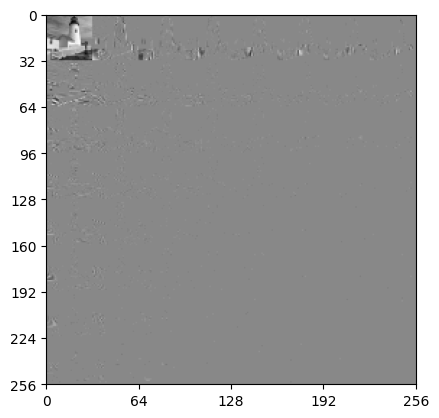

In [10]:
fig, ax = plt.subplots()
plot_image(Yq,ax = ax)

In [11]:
print(bpp(Yq)*Yq.size)

m, n = Yr.shape
N_m, N_n = N, N
Z = Yq.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
Z = Z.transpose((1, 0, 3, 2))                # permute them
Z = Z.reshape(m, n) 

Y_ = Z
Z = ilbt(Y_)
z_max = np.max(Z)
z_min = np.min(Z)
Z = Z * 256/np.abs(z_max - z_min)
Z = Z - np.min(Z)
print(np.min(Z), np.max(Z))
print(np.min(X), np.max(X))

print(bpp(X)*X.size)

77128.50432468178
0.0 255.99999999999994
-128.0 120.0
493398.1567807871


In [12]:
RMS = np.std(Z - X)
print(RMS)
ssim_index = ssim(X+128.0, Z, data_range=Z.max() - Z.min())
psnr_value = psnr(X+128.0, Z, data_range=Z.max() - Z.min())
print("SSIM:", ssim_index)
print("PSNR:", psnr_value)

8.16189631362858
SSIM: 0.894901058336416
PSNR: 27.260270503856034


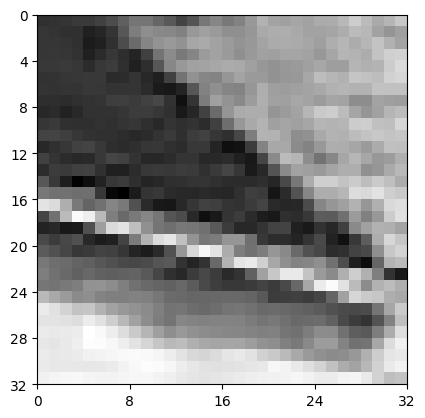

In [13]:
fig, ax = plt.subplots()
plot_image(Z[128:160,128:160],ax = ax)

In [14]:
step = 19
Yq1 = quantise(Y,step,rise1 = step)
print(bpp(Yq1)*Yq1.size)

67544.83486347932


0.0 256.0
-128.0 120.0
6.249651826552737
SSIM: 0.9136710802196762
PSNR: 28.52013111278118


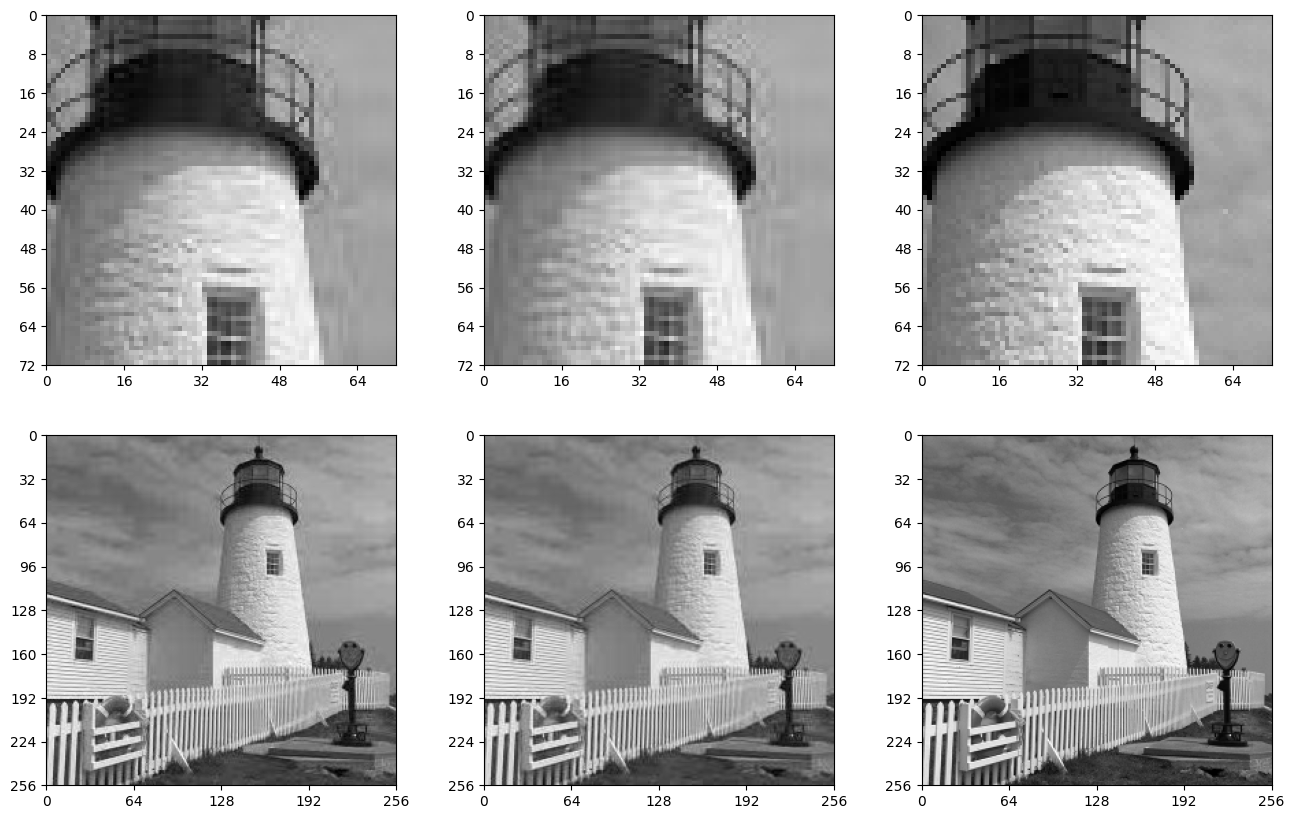

In [15]:
ZZ = ilbt(Yq1)

zz_max = np.max(ZZ)
zz_min = np.min(ZZ)
ZZ = ZZ * 256/np.abs(zz_max - zz_min)
ZZ = ZZ - np.min(ZZ)
print(np.min(ZZ), np.max(ZZ))
print(np.min(X), np.max(X))
fig, axs = plt.subplots(2,3,figsize = (16,10))

plot_image(ZZ[28:100,128:200],ax = axs[0,0])
plot_image(Z[28:100,128:200],ax = axs[0,1])
plot_image(X[28:100,128:200],ax = axs[0,2])

plot_image(ZZ,ax = axs[1,0])
plot_image(Z,ax = axs[1,1])
plot_image(X,ax = axs[1,2])
RMS = np.std(ZZ - X)
print(RMS)
ssim_index = ssim(X+128.0, ZZ, data_range=Z.max() - Z.min())
psnr_value = psnr(X+128.0, ZZ, data_range=Z.max() - Z.min())
print("SSIM:", ssim_index)
print("PSNR:", psnr_value)

In [16]:
vlc, headers = lbtenc(X,17.0)
Z = lbtdec(vlc,17)

Forward 8 x 8 DCT
Quantising to step size of 17.0
Generating huffcode and ehuf using default tables
Coding rows
Bits for coded image = 81303
Generating huffcode and ehuf using default tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT



14.489421154978853


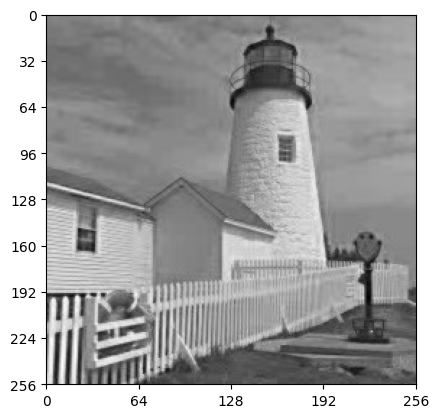

In [17]:
fig, ax = plt.subplots()
plot_image(Z,ax = ax)
RMS = np.std(Z - X)
print(RMS)

In [18]:
ssim_index = ssim(bridge, Z, data_range=Z.max() - Z.min())
psnr_value = psnr(bridge, Z, data_range=Z.max() - Z.min())
print("SSIM:", ssim_index)
print("PSNR:", psnr_value)

SSIM: 0.08570572708377759
PSNR: 11.202841869824987
